In [3]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

In [4]:
model_result_root_dir = '../HetGNN/model_save_clean_mean'
data_root_dir = '../HetGNN/ProcessedData_clean'
model_eval_freq = 2
num_eval = 100

In [12]:
%run processing_init.py

NameError: name 'model' is not defined

In [7]:
train_loss, eval_result = loss_and_eval_results(model_result_root_dir, model_eval_freq)

## Graph Embedding

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
train_gids, eval_gids, test_gids = get_train_eval_test_gids(model_result_root_dir)

In [53]:
import sys
sys.path.append("../HetGNN/code_gcn/")

from data_loader import EventGraphDataset
from GCN import HetGCN

In [40]:
dataset = EventGraphDataset(
    f'{data_root_dir}/node_feature_norm.csv',
    f'{data_root_dir}/graph_het_neigh_list',
    f'{data_root_dir}/node_types.csv',
    unzip=False
)

reading node features..
done


In [56]:
model = HetGCN(model_path=model_result_root_dir)
model.load_checkpoint(30)
model.load_svdd_center()

model

HetGCN(
  (fc_node_content_layers): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): Linear(in_features=7, out_features=7, bias=True)
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): Linear(in_features=7, out_features=7, bias=True)
    (6): Linear(in_features=7, out_features=7, bias=True)
    (7): Linear(in_features=7, out_features=7, bias=True)
  )
  (fc_het_neigh_agg): Linear(in_features=63, out_features=7, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [13]:
model_output(model, dataset[0])

NameError: name 'model' is not defined

In [58]:
trace_info_df = load_trace_info(data_root_dir)
trace_info_df

,trace_id,trace_bool,error_trace_type,process_idx
0,0,True,normal,0
1,1,True,normal,0
2,2,True,normal,0
3,3,True,normal,0
4,4,True,normal,0
...,...,...,...,...
132480,132480,False,F04-02,8
132481,132481,False,F04-02,8
132482,132482,False,F04-02,8
132483,132483,False,F04-02,8


In [59]:
def get_graph_results(model, gid_list, name='train', num_feature=7):
    g_embeddings = []
    g_scores = []
    for gid in tqdm(gid_list):
        _embedding, _score = model_output(model, dataset[gid])
        g_embeddings.append(_embedding)
        g_scores.append(_score)
    g_embeddings = np.array(g_embeddings)
    
    resultdf = pd.DataFrame(g_embeddings, columns=[f'e{i}' for i in range(num_feature)])
    resultdf['scores'] = g_scores
    resultdf['trace_id'] = gid_list
    resultdf['dataset'] = name
    
    resultdf = resultdf.merge(trace_info_df, on='trace_id', how='inner')
    
    resultdf = add_tsne_embedding(resultdf, name=name)
    
    return resultdf

In [60]:
def add_tsne_embedding(resultdf, name='train', num_feature=7):
    tsne_ = TSNE(n_components=2, init='random')
    embeddings = resultdf[[f'e{i}' for i in range(num_feature)]]
    tsne_embeddings = tsne_.fit_transform(embeddings)
    
    resultdf['tsne_x'] = tsne_embeddings[:,0]
    resultdf['tsne_y'] = tsne_embeddings[:,1]
    
    fig = px.scatter(resultdf, x='tsne_x', y='tsne_y', color='trace_bool', title=f'{name} Graph Embeddings')
    fig.show()
    
    return resultdf
    

In [61]:
train_result_df = get_graph_results(model, train_gids, name='train')
train_result_df

100%|██████████| 200/200 [00:37<00:00,  5.30it/s]


,e0,e1,e2,e3,e4,e5,e6,scores,trace_id,dataset,trace_bool,error_trace_type,process_idx,tsne_x,tsne_y
0,0.520535,0.515478,0.456913,0.509961,0.498815,0.568031,0.530657,2.1193752e-07,20897,train,True,normal,1,-1.263557,-3.405915
1,0.520501,0.515456,0.456903,0.509966,0.498823,0.568028,0.530672,2.095012e-07,49689,train,True,normal,3,-4.407766,-11.033535
2,0.520529,0.515480,0.456926,0.509963,0.498822,0.568048,0.530674,2.1283313e-07,72616,train,True,normal,4,4.046987,-6.796407
3,0.520535,0.515466,0.456904,0.509957,0.498799,0.568042,0.530646,2.0852288e-07,50897,train,True,normal,3,-3.738350,-4.054055
4,0.520511,0.515449,0.456905,0.509963,0.498816,0.568034,0.530678,2.0855681e-07,68786,train,True,normal,4,-5.157614,-10.506175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.520514,0.515459,0.456931,0.509911,0.498786,0.568107,0.530660,2.0979348e-07,24275,train,True,normal,1,-16.760588,0.526813
196,0.520533,0.515484,0.456918,0.509962,0.498813,0.568040,0.530661,2.1158912e-07,128167,train,True,normal,8,0.156953,-4.676550
197,0.520468,0.515438,0.456940,0.509974,0.498858,0.568086,0.530736,2.133975e-07,4886,train,True,normal,0,28.008453,15.156784
198,0.520504,0.515476,0.456937,0.509930,0.498798,0.568097,0.530667,2.1156735e-07,61839,train,True,normal,4,-15.174058,2.141134


In [62]:
eval_result_df = get_graph_results(model, eval_gids[:100], name='eval')
eval_result_df

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


,e0,e1,e2,e3,e4,e5,e6,scores,trace_id,dataset,trace_bool,error_trace_type,process_idx,tsne_x,tsne_y
0,0.520511,0.515449,0.456904,0.509963,0.498816,0.568034,0.530677,2.0839352e-07,85659,eval,True,normal,5,-4.028483,0.170344
1,0.520504,0.515476,0.456937,0.509930,0.498798,0.568098,0.530667,2.1163416e-07,66442,eval,True,normal,4,-1.499886,8.115198
2,0.520467,0.515438,0.456941,0.509973,0.498859,0.568085,0.530737,2.1366614e-07,114647,eval,True,normal,7,-2.307249,-4.981763
3,0.520536,0.515484,0.456918,0.509966,0.498819,0.568026,0.530658,2.1386404e-07,20554,eval,True,normal,1,-8.752746,0.882643
4,0.520535,0.515473,0.456908,0.509958,0.498809,0.568030,0.530648,2.1132443e-07,117421,eval,True,normal,7,-8.530957,1.935492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.520535,0.515473,0.456908,0.509958,0.498809,0.568030,0.530648,2.1132443e-07,73182,eval,True,normal,4,-8.531454,1.933039
96,0.520533,0.515484,0.456918,0.509961,0.498814,0.568042,0.530661,2.1160663e-07,128335,eval,True,normal,8,-7.767336,0.934551
97,0.520468,0.515438,0.456940,0.509974,0.498858,0.568086,0.530736,2.1341027e-07,53583,eval,True,normal,3,-2.496448,-4.614780
98,0.520543,0.515442,0.456892,0.509946,0.498784,0.568053,0.530630,2.0555704e-07,40488,eval,False,F03-04,2,-4.449541,3.587320


In [65]:
px.scatter(eval_result_df, x='tsne_x', y='tsne_y', color='error_trace_type', title='Eval Graph Embeddings')

In [64]:
px.histogram(train_result_df, x='scores', color='error_trace_type', title='Train Scores').show()
px.histogram(eval_result_df, x='scores', color='error_trace_type', title='Eval Scores')

In [72]:
dataset[0][1]

tensor([[[[ 2.2004e-04,  6.1784e-05,  2.3899e-04,  ...,  0.0000e+00,
            5.2851e-05,  2.1643e-04],
          [ 2.2068e-04,  1.0297e-04,  2.3899e-04,  ...,  0.0000e+00,
            7.0469e-05,  2.1848e-04],
          [ 2.2004e-04,  6.1784e-05,  2.3899e-04,  ...,  0.0000e+00,
            2.0994e-04,  2.1643e-04],
          ...,
          [ 2.2101e-04,  6.1784e-05,  2.3899e-04,  ...,  0.0000e+00,
            8.8086e-05,  2.1927e-04],
          [ 2.2068e-04,  1.0297e-04,  2.3899e-04,  ...,  0.0000e+00,
            8.2213e-05,  2.1848e-04],
          [ 2.2101e-04,  6.1784e-05,  2.3899e-04,  ...,  0.0000e+00,
            1.4681e-04,  2.1927e-04]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
     

In [69]:
model_children = list(model.children())
model_children

[ModuleList(
   (0): Linear(in_features=7, out_features=7, bias=True)
   (1): Linear(in_features=7, out_features=7, bias=True)
   (2): Linear(in_features=7, out_features=7, bias=True)
   (3): Linear(in_features=7, out_features=7, bias=True)
   (4): Linear(in_features=7, out_features=7, bias=True)
   (5): Linear(in_features=7, out_features=7, bias=True)
   (6): Linear(in_features=7, out_features=7, bias=True)
   (7): Linear(in_features=7, out_features=7, bias=True)
 ),
 Linear(in_features=63, out_features=7, bias=True),
 LeakyReLU(negative_slope=0.01),
 Sigmoid()]

In [78]:
graph_node_feature, graph_het_feature, graph_node_types = dataset[0]

In [85]:
sp = graph_het_feature[0].shape
graph_het_feature[0].reshape(sp[0]*sp[1], sp[2])

tensor([[2.2004e-04, 6.1784e-05, 2.3899e-04,  ..., 0.0000e+00, 5.2851e-05,
         2.1643e-04],
        [2.2068e-04, 1.0297e-04, 2.3899e-04,  ..., 0.0000e+00, 7.0469e-05,
         2.1848e-04],
        [2.2004e-04, 6.1784e-05, 2.3899e-04,  ..., 0.0000e+00, 2.0994e-04,
         2.1643e-04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [89]:
model_children[0][0](graph_het_feature[0].reshape(sp[0]*sp[1], sp[2])).reshape(sp)[0]

tensor([[0.0974, 0.0971, 0.0974, 0.0970, 0.0969, 0.0976, 0.0971],
        [0.0974, 0.0971, 0.0974, 0.0970, 0.0969, 0.0976, 0.0971],
        [0.0974, 0.0971, 0.0974, 0.0971, 0.0969, 0.0977, 0.0970],
        [0.0974, 0.0971, 0.0974, 0.0971, 0.0969, 0.0977, 0.0970],
        [0.0975, 0.0972, 0.0974, 0.0971, 0.0968, 0.0977, 0.0971],
        [0.0974, 0.0971, 0.0974, 0.0972, 0.0969, 0.0977, 0.0970],
        [0.0975, 0.0972, 0.0973, 0.0973, 0.0969, 0.0978, 0.0970],
        [0.0974, 0.0971, 0.0974, 0.0970, 0.0969, 0.0977, 0.0971],
        [0.0974, 0.0971, 0.0974, 0.0970, 0.0969, 0.0977, 0.0971],
        [0.0974, 0.0971, 0.0974, 0.0971, 0.0969, 0.0977, 0.0970]],
       grad_fn=<SelectBackward0>)

In [88]:
import matplotlib.pyplot as plt

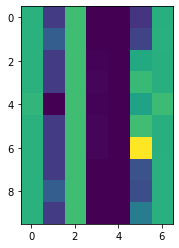

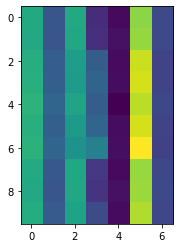

In [96]:
nodeid = 0
plt.imshow(graph_het_feature[0][nodeid])
plt.show()
plt.imshow(model_children[0][0](graph_het_feature[0].reshape(sp[0]*sp[1], sp[2])).reshape(sp)[nodeid].detach().numpy())